# Illegal zoning
_they made the character of our neighboorhoods illegal_

Waltham, like a lot of other cities with zoning codes, has a bit of a silly problem.
You see, the zoning is so restrictive in some places, that the existing structures could not be rebuilt.
Everything would have to go through a special permit, which is time consuming and expensive. You can imagine a lot of people
wouldn't even bother and just build where the zoning is easier.

What's the scale of the problem?

In [1]:
from dvc.api import DVCFileSystem
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
import geopandas as geo_pd
from dbfread import DBF


# plotting
import seaborn as sns

%matplotlib inline

# constants
SQ_FT_PER_ACRE = 43560

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")

## Load shapefiles for buildings, zones, and parcels as well as the tax assessments data

In [2]:
with fs.open(f"data/gis/L3_SHP_M308_WALTHAM.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/L3_SHP_M308_Waltham/M308TaxPar_CY22_FY23.shp"
    property_shapefiles_df = geo_pd.read_file(shp_path)
    # filter out right of way and water etc. property types
    property_shapefiles_df = property_shapefiles_df[property_shapefiles_df["POLY_TYPE"] == "FEE"]
    property_shapefiles_df = property_shapefiles_df[["LOC_ID", "geometry"]]

    assessments_table = DBF(f"../../data/gis/L3_SHP_M308_Waltham/M308Assess_CY22_FY23.dbf", load=True)

    assessments_df = pd.DataFrame([dict(r) for r in assessments_table.records])
    assessments_df = assessments_df[["LOC_ID", "SITE_ADDR", "LOT_SIZE", "YEAR_BUILT", "UNITS", "RES_AREA", "STORIES", "USE_CODE", "BLD_AREA"]]

In [3]:
assessments_df.head()

LOC_ID        SITE_ADDR  LOT_SIZE  YEAR_BUILT  UNITS  RES_AREA  \
0  F_734012_2963106  31  CLEMENTS RD      0.11        1930      1      1352   
1  F_730830_2973583     4  ABBOTT RD      0.22        1962      1      1931   
2  F_730659_2973534    15  ABBOTT RD      0.21        1952      1      1756   
3  F_730718_2973342    22  ABBOTT RD      0.23        1952      1      2922   
4  F_730548_2973294    33  ABBOTT RD      0.21        1952      1      1792   

  STORIES USE_CODE  BLD_AREA  
0       2      101      1352  
1       1      101      1931  
2       2      101      1756  
3       2      101      2922  
4       2      101      1792

In [4]:
property_shapefiles_df.head()

LOC_ID                                           geometry
0  F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...
1  F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...
2  F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...
3  F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...
4  F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...

In [5]:
shp_path = f"../../data/Buildings/Buildings.shp"
buildings_df = geo_pd.read_file(shp_path)
buildings_df = buildings_df[["geometry"]]

# assign MassGIS CRS
buildings_df.to_crs(property_shapefiles_df.crs, inplace=True)
buildings_df.head()

geometry
0  POLYGON ((219179.561 908215.757, 219174.404 90...
1  POLYGON ((219207.717 908210.616, 219205.988 90...
2  POLYGON ((219181.783 908206.625, 219176.641 90...
3  POLYGON ((219192.485 908186.819, 219192.235 90...
4  POLYGON ((219235.340 908191.010, 219235.404 90...

## The zoning rules table

This data comes from `Sec. 4.11. Table of Dimensional Regulations` of the city zoning code.

https://ecode360.com/attachment/WA1697/WA1697-Ze%20Table%20of%20Dimentional%20Regulations.pdf

I selected rows that apply to multi-family housing when the table had a more complex case defined per-use type.

Units are in feet for the most part, except for stories, FAR, lot coverage %, min open space % and max dwelling unit / acre values.

In [6]:
zoning_rules_df = pd.read_csv("../../data/zoning_rules_table.csv")
zoning_rules_df.set_index("District", inplace=True)
zoning_rules_df.head()

front setback  side setback  rear setback  height  stories  \
District                                                               
RA1                  40            20            40      35      2.5   
RA2                  40            20            40      35      2.5   
RA3                  25            15            30      35      2.5   
RA4                  25            15            30      35      2.5   
RB                   15            10            30      40      3.0   

          FAR by right  max lot coverage  min open space  lot area  max DUA  \
District                                                                      
RA1                NaN              0.20             NaN   20000.0      NaN   
RA2                NaN              0.20             NaN   15000.0      NaN   
RA3                NaN              0.25             NaN    9600.0      NaN   
RA4                NaN              0.25             NaN    7000.0      NaN   
RB                 NaN              0.30             NaN    6000.0      NaN   

          lot frontage  
District                
RA1                100  
RA2                 80  
RA3                 70  
RA4                 60  
RB                  60

In [7]:
with fs.open(f"data/gis/WalthamZoning.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/WalthamZoning/WalthamZoning.shp"
    zoning_df = geo_pd.read_file(shp_path)

# set the waltham zoning crs to match the MassGIS one
zoning_df.to_crs(property_shapefiles_df.crs, inplace=True)

In [8]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geometry"] = property_shapefiles_df["geometry"]
property_shapefiles_df["geometry"] = property_shapefiles_df.centroid
zoned_parcels_df = property_shapefiles_df.sjoin(zoning_df, how="left")
zoned_parcels_df.drop(axis="columns", labels=["index_right", "geometry"], inplace=True)
zoned_parcels_df.rename(columns={"NAME": "ZONE", "parcel_geometry": "geometry"}, inplace=True)
zoned_parcels_df = zoned_parcels_df[["LOC_ID", "geometry", "ZONE"]]

zoned_parcels_df = zoned_parcels_df[~zoned_parcels_df["ZONE"].isna()]

In [9]:
zoned_parcels_df.head(100)

LOC_ID                                           geometry ZONE
0    F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...  RA3
1    F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...  RA3
2    F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...  RA3
3    F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...  RA3
4    F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...  RA3
..                ...                                                ...  ...
98   F_721106_2955606  POLYGON ((219836.030 900873.330, 219774.384 90...   RC
99   F_719877_2955687  POLYGON ((219440.509 900912.633, 219440.166 90...  RA3
100  F_722055_2955676  POLYGON ((220100.815 900877.988, 220073.624 90...  RA3
101  F_722277_2955700  POLYGON ((220134.904 900877.797, 220133.218 90...  RA3
102  F_720103_2955682  POLYGON ((219485.805 900872.219, 219481.976 90...  RA3

[100 rows x 3 columns]

In [10]:
# assign buildings to zones
zoned_buildings_df = buildings_df.sjoin(zoning_df, how="left", predicate="within")
zoned_buildings_df = zoned_buildings_df[["geometry", "NAME"]]
zoned_buildings_df.rename(columns={"NAME": "ZONE"}, inplace=True)
zoned_buildings_df.head()

geometry ZONE
0  POLYGON ((219179.561 908215.757, 219174.404 90...  RA2
1  POLYGON ((219207.717 908210.616, 219205.988 90...  RA2
2  POLYGON ((219181.783 908206.625, 219176.641 90...  RA2
3  POLYGON ((219192.485 908186.819, 219192.235 90...  RA2
4  POLYGON ((219235.340 908191.010, 219235.404 90...  RA2

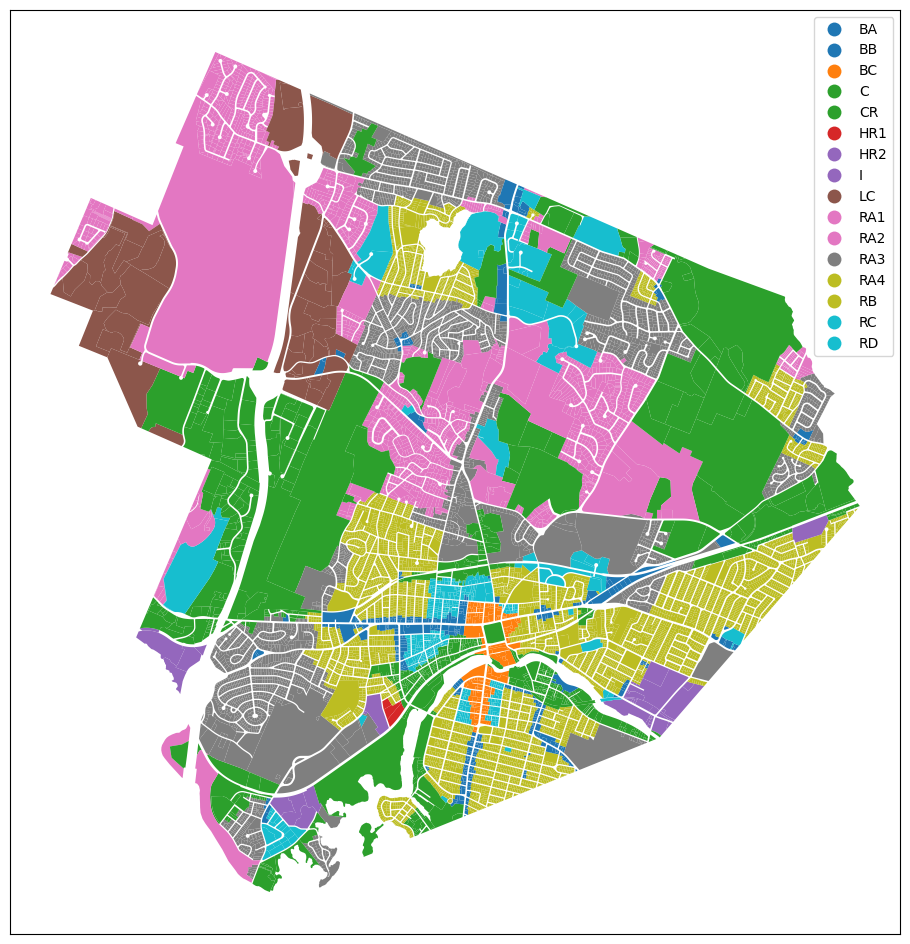

In [11]:
ax = zoned_parcels_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

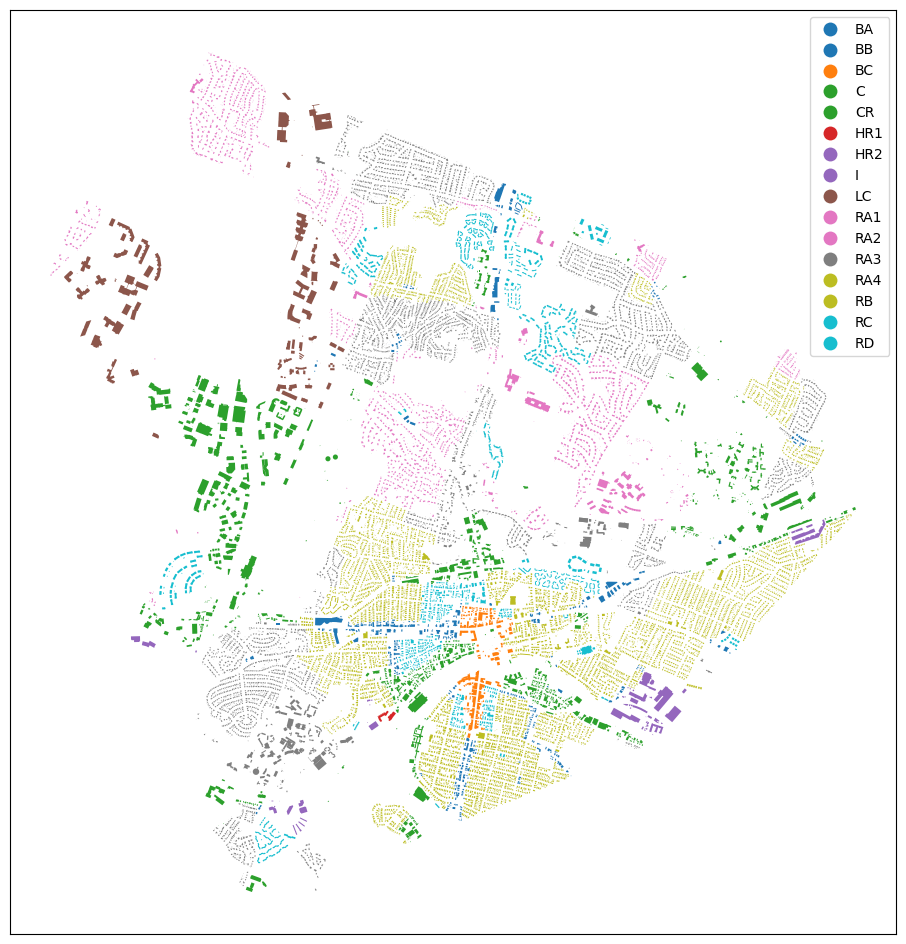

In [12]:
ax = zoned_buildings_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Non-compliance

Parcels might not comply if they're too small. Structures wouldn't comply based on their shape or closeness to each other. FAR and setback violations turn out to be pretty hard to calculate so we'll skip that for now.

### Parcel size
Some zones have a minimum parcel size requirement.

In [13]:
zoned_parcels_df = zoned_parcels_df.merge(assessments_df, how="left", on=["LOC_ID"])

In [14]:
# cleanup of some bad data (like sliver parcels)
zoned_parcels_df = zoned_parcels_df[~zoned_parcels_df["LOT_SIZE"].isna()]

In [15]:
zoned_parcels_df.head()

LOC_ID                                           geometry ZONE  \
0  F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...  RA3   
1  F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...  RA3   
2  F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...  RA3   
3  F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...  RA3   
4  F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...  RA3   

             SITE_ADDR  LOT_SIZE  YEAR_BUILT  UNITS  RES_AREA STORIES  \
0        759  SOUTH ST      0.15      1975.0    1.0    1612.0       2   
1     753 -55 SOUTH ST      0.22      1860.0    2.0    5678.0       3   
2  72 LOT EDGEWATER DR      0.11         0.0    0.0       0.0           
3        757  SOUTH ST      0.35      1975.0    1.0     960.0       1   
4        749  SOUTH ST      0.15      1960.0    1.0    1517.0       2   

  USE_CODE  BLD_AREA  
0      101    1612.0  
1      104    5678.0  
2      132       0.0  
3      101     960.0  
4      101    1517.0

In [16]:
zoning_rules_df.head(25)

front setback  side setback  rear setback  height  stories  \
District                                                               
RA1                  40            20            40      35      2.5   
RA2                  40            20            40      35      2.5   
RA3                  25            15            30      35      2.5   
RA4                  25            15            30      35      2.5   
RB                   15            10            30      40      3.0   
RC                   10            10            20      40      3.0   
RD                   75            45            60      50      4.0   
HR1                  10            10            10      74      6.0   
HR2                  10            10            20      74      6.0   
BA                   10             0            15      36      3.0   
BB                    0             0            25      48      4.0   
BC                    0             0            25      65      5.0   
LC                  150           100           100      40      3.0   
C                    10            15            25      80      8.0   
I                    10            15            25      80      8.0   
CR                  100           100           100      20      1.0   

          FAR by right  max lot coverage  min open space  lot area  max DUA  \
District                                                                      
RA1                NaN              0.20             NaN   20000.0      NaN   
RA2                NaN              0.20             NaN   15000.0      NaN   
RA3                NaN              0.25             NaN    9600.0      NaN   
RA4                NaN              0.25             NaN    7000.0      NaN   
RB                 NaN              0.30             NaN    6000.0      NaN   
RC                0.20              0.30            0.15    6000.0      6.0   
RD                0.20              0.30            0.15  217800.0      6.0   
HR1               1.80              0.75             NaN   10000.0     59.0   
HR2               0.01              0.75             NaN   10000.0      3.0   
BA                0.20              0.30            0.15    6000.0      6.0   
BB                0.25              0.35            0.15    6000.0     10.0   
BC                1.00              0.90             NaN       NaN     30.0   
LC                0.25              0.30            0.25  217800.0      NaN   
C                 0.40               NaN             NaN   10000.0      NaN   
I                 0.40               NaN             NaN       0.0      NaN   
CR                0.05              0.05            0.10  174240.0      0.0   

          lot frontage  
District                
RA1                100  
RA2                 80  
RA3                 70  
RA4                 60  
RB                  60  
RC                  50  
RD                  50  
HR1                 50  
HR2                 50  
BA                  50  
BB                  50  
BC                  40  
LC                 400  
C                   50  
I                   50  
CR                 100

In [17]:
def parcel_too_small(row):
    """
    returns True if the
    parcel is too small,
    False if there's no requirement
    or parcel is large enough
    """
    zone = row["ZONE"]
    min_lot_size = zoning_rules_df.at[zone, "lot area"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if min_lot_size == float('nan'):
        return False
    elif row["LOT_SIZE"] == float('nan') or row["LOT_SIZE"] == 0:
        return False
    
    return (row["LOT_SIZE"] * SQ_FT_PER_ACRE < min_lot_size)

zoned_parcels_df["parcel_too_small"] = zoned_parcels_df.apply(lambda row: parcel_too_small(row), axis=1)

In [18]:
zoned_parcels_df["parcel_too_small"].value_counts()

parcel_too_small
False    9445
True     7063
Name: count, dtype: int64

In [19]:
len(zoned_parcels_df[zoned_parcels_df["parcel_too_small"]]) / len(zoned_parcels_df)

0.42785316210322266

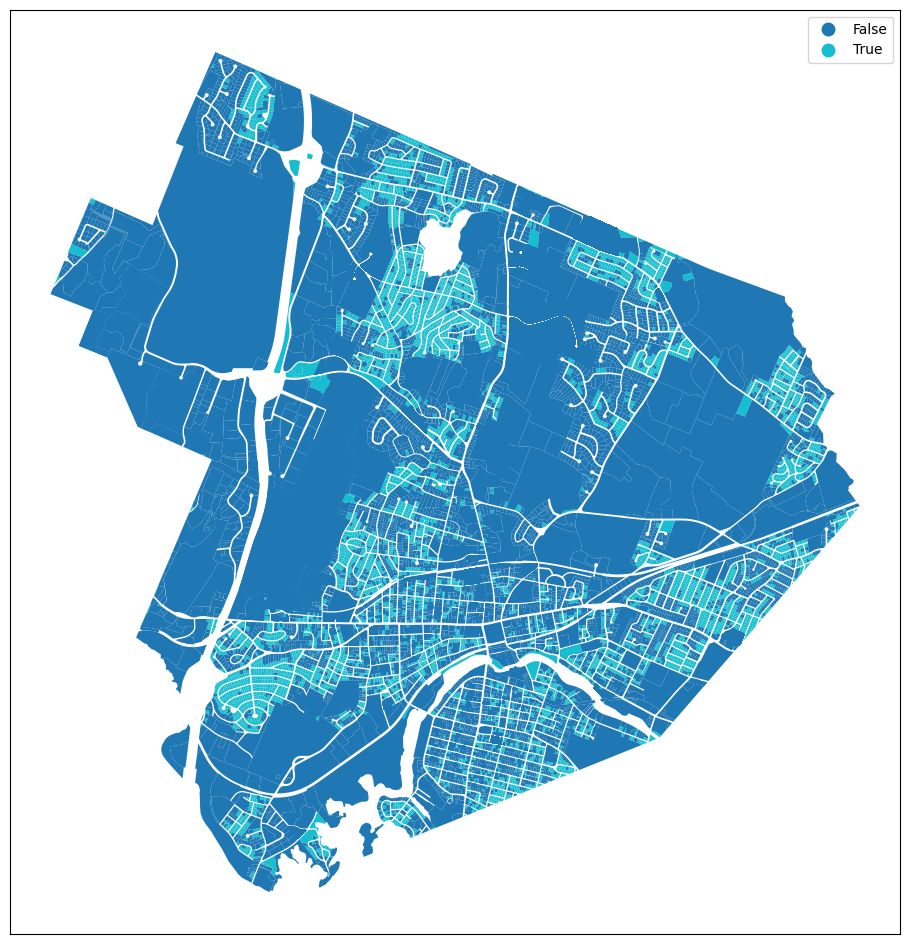

In [20]:
ax = zoned_parcels_df.plot(column="parcel_too_small", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

### Too many stories
The meaning should be obvious...

In [21]:
def too_many_stories(row):
    """
    returns True if the
    structure on the parcel
    has too many stories,
    False if there's no requirement
    """
    zone = row["ZONE"]
    stories = zoning_rules_df.at[zone, "stories"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if stories == float('nan') or stories == "":
        return False
    elif row["STORIES"] == float('nan') or row["STORIES"] == "":
        return False

    return (float(row["STORIES"]) > float(stories))

zoned_parcels_df["too_many_stories"] = zoned_parcels_df.apply(lambda row: too_many_stories(row), axis=1)

In [22]:
zoned_parcels_df["too_many_stories"].value_counts()

too_many_stories
False    16268
True       240
Name: count, dtype: int64

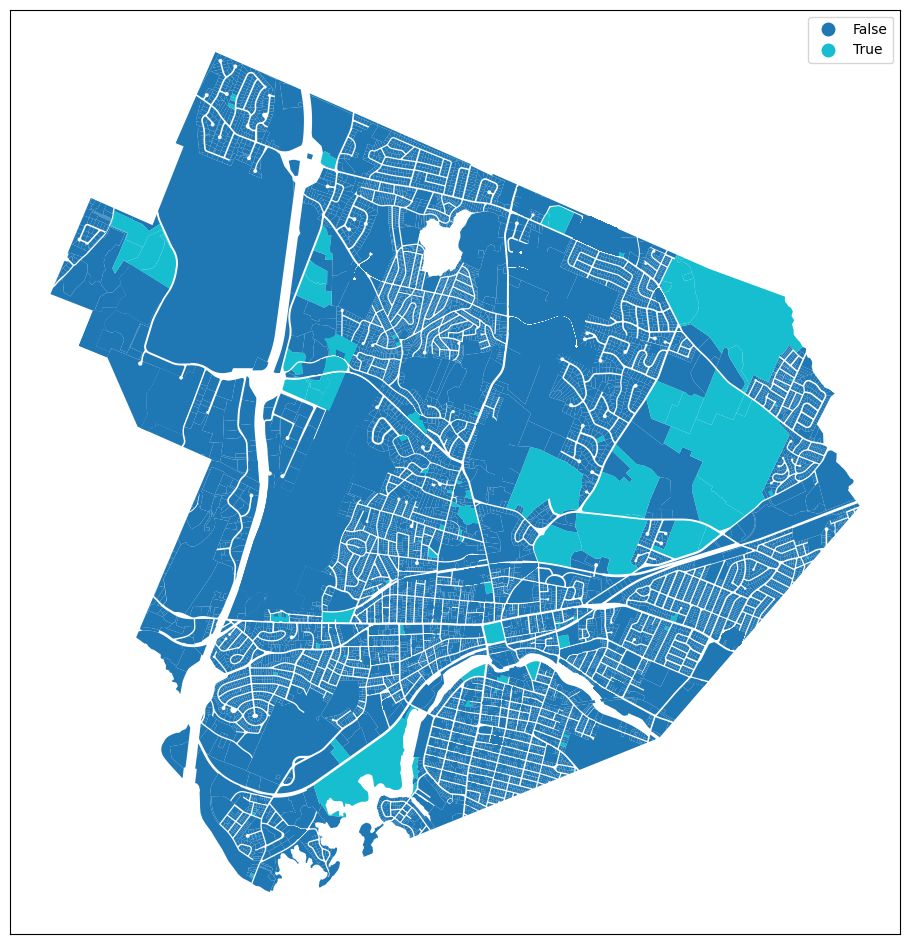

In [23]:
ax = zoned_parcels_df.plot(column="too_many_stories", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

In [24]:
zoned_parcels_df["USE_CODE"]

0        101
1        104
2        132
3        101
4        101
        ... 
16528    101
16529    101
16530    101
16531    101
16532    101
Name: USE_CODE, Length: 16508, dtype: object

### Dwelling units per acre too high
Too many housing units in an acre

In [25]:

def too_many_units_per_acre(row):
    """
    returns True if the parcel has
    too many units / acre, for
    residential use codes
    """

    # residential use codes
    if int(row["USE_CODE"]) not in range(100, 200):
        return False

    zone = row["ZONE"]
    max_dua = zoning_rules_df.at[zone, "max DUA"]
    as_built_units = row["UNITS"]
    lot_size = row["LOT_SIZE"]

    # no requirement for this parcel or parcel is somehow
    # zero size
    if pd.isna(max_dua) or max_dua == "":
        return False
    elif as_built_units == float('nan') or as_built_units == "" or lot_size == 0:
        return False

    return as_built_units / lot_size > max_dua

zoned_parcels_df["too_many_units_per_acre"] = zoned_parcels_df.apply(lambda row: too_many_units_per_acre(row), axis=1)

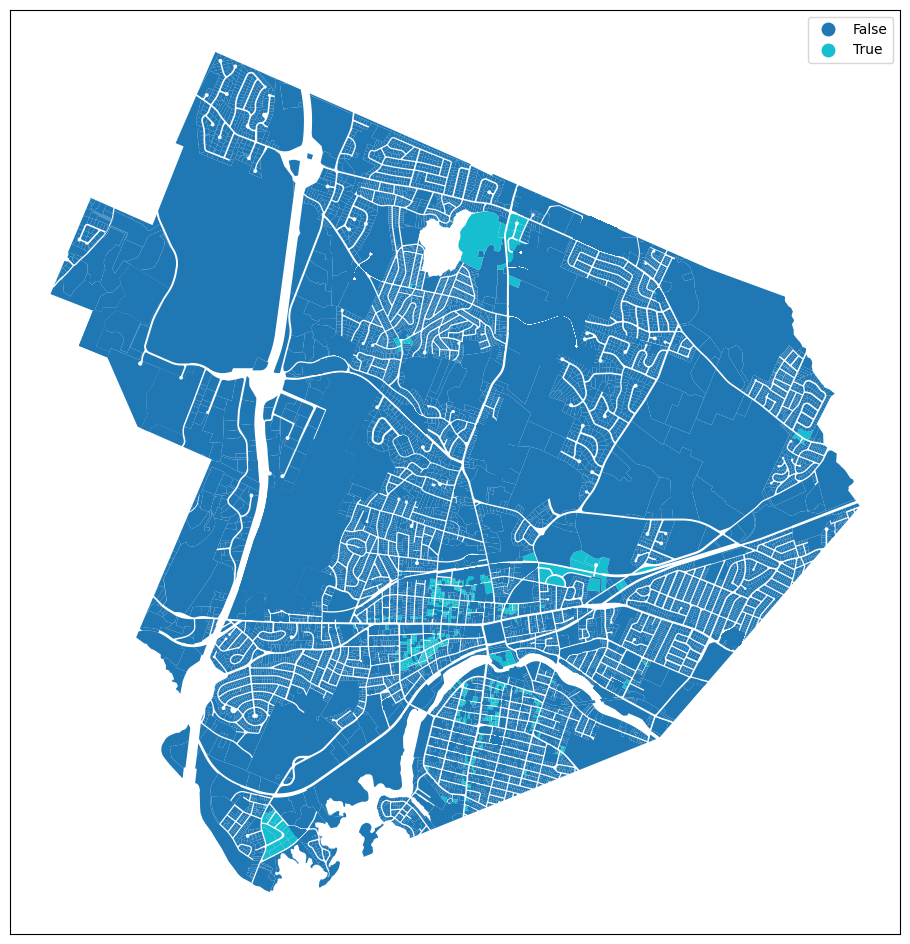

In [26]:
ax = zoned_parcels_df.plot(column="too_many_units_per_acre", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

leg = ax.get_legend()

## All parcels that are illegal
(any combination of zoning violations)

In [27]:
def any_violations(row):
    "returns True for any violation"
    
    return row["parcel_too_small"] or row["too_many_stories"] or row["too_many_units_per_acre"]

zoned_parcels_df["any_violations"] = zoned_parcels_df.apply(lambda row: any_violations(row), axis=1)

In [28]:
zoned_parcels_df["any_violations"].value_counts()

any_violations
False    8987
True     7521
Name: count, dtype: int64

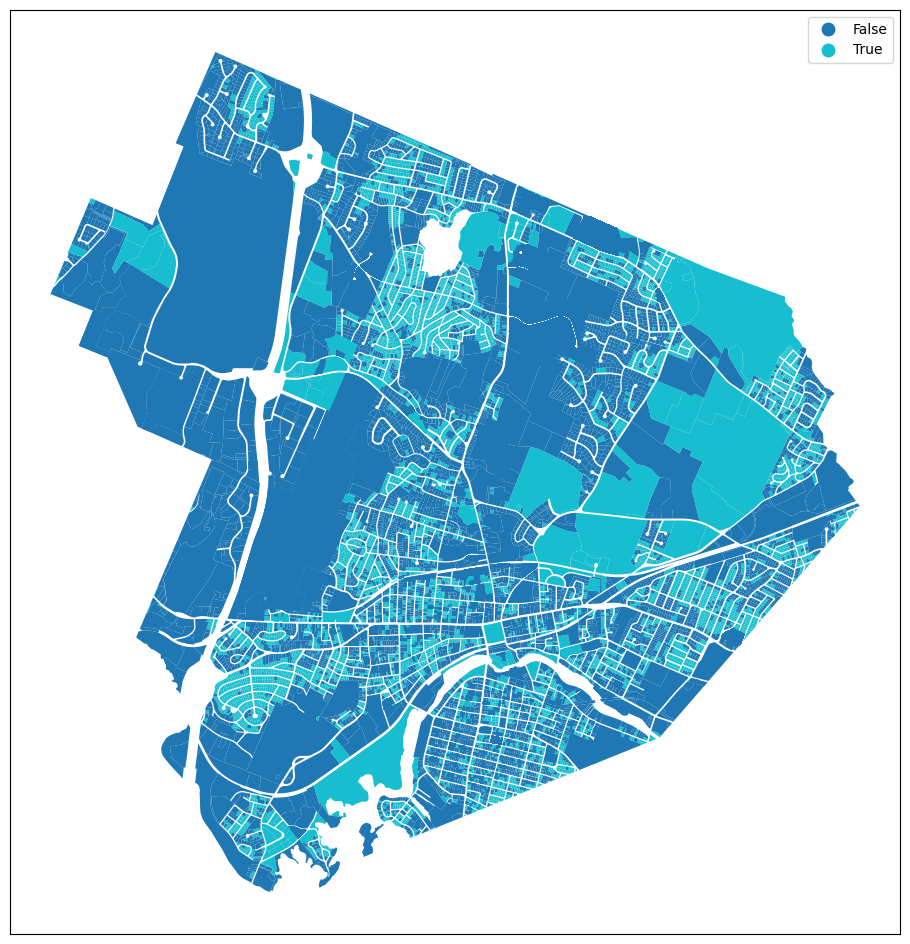

In [29]:
ax = zoned_parcels_df.plot(column="any_violations", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [30]:
zoned_parcels_df[zoned_parcels_df["too_many_units_per_acre"]]

LOC_ID                                           geometry  \
42     F_720589_2955137  POLYGON ((219655.074 900764.440, 219677.996 90...   
67     F_720898_2955298  POLYGON ((219805.505 900785.392, 219789.593 90...   
68     F_720699_2955372  POLYGON ((219713.729 900797.816, 219655.074 90...   
82     F_720902_2955486  POLYGON ((219772.811 900834.310, 219713.729 90...   
83     F_721194_2955471  POLYGON ((219866.195 900824.597, 219847.329 90...   
...                 ...                                                ...   
16478  F_727162_2958788  POLYGON ((221644.812 901821.446, 221624.990 90...   
16479  F_727135_2958683  POLYGON ((221644.812 901821.446, 221638.277 90...   
16481  F_727253_2959314  POLYGON ((221664.992 901987.848, 221665.176 90...   
16502  F_725837_2963060  POLYGON ((221255.775 903149.184, 221253.862 90...   
16524  F_720792_2956484  POLYGON ((219679.427 901131.940, 219680.218 90...   

      ZONE                SITE_ADDR  LOT_SIZE  YEAR_BUILT  UNITS  RES_AREA  \
42      RC  18 -20 CHARLES RIVER RD      0.98      1960.0   18.0   19398.0   
67      RC  30 -60 CHARLES RIVER RD      1.78      1960.0   36.0   39600.0   
68      RC  106 -16 CHARLESBANK WAY      0.90      1960.0   18.0   19296.0   
82      RC  90 -100 CHARLESBANK WAY      0.80      1960.0   18.0   19800.0   
83      RC  70 -80 CHARLES RIVER RD      0.94      1960.0   18.0   19200.0   
...    ...                      ...       ...         ...    ...       ...   
16478   BA             11  ALDER ST      0.17      2017.0    6.0    7006.0   
16479   BA            10  MYRTLE ST      0.17      2017.0    6.0    7006.0   
16481   BC          95  CHESTNUT ST      0.10      1910.0    4.0    4634.0   
16502   RC             63  BACON ST      0.17      2020.0    2.0    4131.0   
16524   RC        34 -36 ANTICO WAY      0.21      1955.0    4.0    3040.0   

      STORIES USE_CODE  BLD_AREA  parcel_too_small  too_many_stories  \
42          2      112   19398.0             False             False   
67          2      112   39600.0             False             False   
68          2      112   19296.0             False             False   
82          2      112   19800.0             False             False   
83          2      112   19200.0             False             False   
...       ...      ...       ...               ...               ...   
16478       3      111    7006.0             False             False   
16479       3      111    7006.0             False             False   
16481       2      111    4634.0             False             False   
16502       3      104    4131.0             False             False   
16524       2      111    3040.0             False             False   

       too_many_units_per_acre  any_violations  
42                        True            True  
67                        True            True  
68                        True            True  
82                        True            True  
83                        True            True  
...                        ...             ...  
16478                     True            True  
16479                     True            True  
16481                     True            True  
16502                     True            True  
16524                     True            True  

[533 rows x 15 columns]

In [31]:
zoned_parcels_df.to_file("derived/illegal_zoning.shp")
zoned_parcels_df.to_gbq

C:\Users\Timothy Riley\AppData\Local\Temp\ipykernel_1652\1615129531.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  zoned_parcels_df.to_file("derived/illegal_zoning.shp")


<bound method DataFrame.to_gbq of                  LOC_ID                                           geometry  \
0      F_720118_2954451  POLYGON ((219510.406 900516.563, 219505.564 90...   
1      F_720144_2954524  POLYGON ((219521.229 900544.743, 219512.577 90...   
2      F_722474_2954539  POLYGON ((220212.276 900527.633, 220199.657 90...   
3      F_720055_2954540  POLYGON ((219481.807 900560.359, 219483.941 90...   
4      F_720183_2954604  POLYGON ((219530.434 900568.770, 219524.316 90...   
...                 ...                                                ...   
16528  F_719877_2961772  POLYGON ((219425.636 902734.138, 219402.377 90...   
16529  F_736247_2969777  POLYGON ((224425.142 905189.026, 224420.241 90...   
16530  F_724665_2970529  POLYGON ((220895.671 905409.290, 220859.653 90...   
16531  F_731940_2972635  POLYGON ((223107.742 906048.523, 223078.254 90...   
16532  F_731747_2973216  POLYGON ((223019.044 906229.286, 223019.965 90...   

      ZONE            SITE_AD